# Training of a Twin Network model: Zebrafish (Danio rerio)

# Table of Contents
* [General](#first-bullet)
* [Load dataset](#second-bullet)
* [Load model](#third-bullet)
* [Training](#fourth-bullet)

## General <a class="anchor" id="first-bullet"></a>

General imports and class definitions

In [1]:
%load_ext autoreload
%autoreload 2

Import Python packages

In [2]:
import datetime
import json
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
from tensorflow.keras import layers

from twinnet_tools.tnconfig import ProjectConfig
from twinnet_tools.tnmodel import TNToolsDistanceLayer
from twinnet_tools.tnmodel import TNToolsModel
from twinnet_tools.tntraining import TNToolsTrainingImages, TNToolsTrainingPaths

os.environ["OPENCV_LOG_LEVEL"]="FATAL"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Load config file and paths from config file

In [3]:
config = ProjectConfig("twinnet_config")

ProjectConfig: C:\TwinNet-main\code\Scripts\twinnet_config\Windows\config.json


In [4]:
config_paths_script = config.json["TrainingZebrafish1"]
dir_data_src = config_paths_script["dir_data_src"]
dir_data_dst = config_paths_script["dir_data_dst"]

print("Input directory: ", dir_data_src)
print("Output directory: ", dir_data_dst)

Input directory:  C:/TwinNet-main/data/Training_Zebrafish1/10.48606-80/data/dataset/TwinNetworkDataset022/Dataset022/
Output directory:  C:/TwinNet-main/results/11_Training_Zebrafish1


Prepare paths to save outputs to

In [5]:
modelId="model1"

# Output path
outFolder = f"{dir_data_dst}/{modelId}"

if not os.path.exists(outFolder):
    os.makedirs(outFolder)

Make tool instances

In [6]:
img_height, img_width = 224, 224 
it = TNToolsTrainingImages(img_height, 300, img_width, 300)
pg = TNToolsTrainingPaths(img_height, 300, img_width, 300, pattern_glob_files="*.tif")

Training parameters

In [7]:
batchSize = 4 #64 batchSize=>4
image_count = 1000 #100000

## Load dataset <a class="anchor" id="second-bullet"></a>

Load paths of datasets to use for image triplet preparation

In [8]:
list_paths_datasets_directories = [dir_data_src]
list_paths_jsons_exclude = [str(i) + '/EMBRYOS_TO_EXCLUDE.json' for i in list_paths_datasets_directories]

print(list_paths_datasets_directories)

['C:/TwinNet-main/data/Training_Zebrafish1/10.48606-80/data/dataset/TwinNetworkDataset022/Dataset022/']


Sort image paths to image triplets

In [9]:
paths_anchor, paths_positive, paths_negative = pg.procedure_paths_binary(list_paths_datasets_directories,
                                                                         list_paths_jsons_exclude,
                                                                         image_count)

[INFO] Loading image paths.
[INFO] Excluding 0 embryo directories.


In [10]:
paths_anchor2, paths_positive2, paths_negative2 = pg.procedure_paths_binary(list_paths_datasets_directories,
                                                                            list_paths_jsons_exclude,
                                                                            image_count)

[INFO] Loading image paths.
[INFO] Excluding 0 embryo directories.


In [11]:
paths_anchor3, paths_positive3, paths_negative3 = pg.procedure_paths_binary(list_paths_datasets_directories,
                                                                            list_paths_jsons_exclude,
                                                                            image_count)

[INFO] Loading image paths.
[INFO] Excluding 0 embryo directories.


Make tensorflow datasets

In [12]:
dataset_anchor = tf.data.Dataset.from_tensor_slices(paths_anchor)
dataset_positive = tf.data.Dataset.from_tensor_slices(paths_positive)
dataset_negative = tf.data.Dataset.from_tensor_slices(paths_negative)

dataset = tf.data.Dataset.zip((dataset_anchor, dataset_positive, dataset_negative))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(it.parse_triple_fn)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(batchSize, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(batchSize, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [13]:
dataset_anchor2 = tf.data.Dataset.from_tensor_slices(paths_anchor2)
dataset_positive2 = tf.data.Dataset.from_tensor_slices(paths_positive2)
dataset_negative2 = tf.data.Dataset.from_tensor_slices(paths_negative2)

dataset2 = tf.data.Dataset.zip((dataset_anchor2, dataset_positive2, dataset_negative2))
dataset2 = dataset2.shuffle(buffer_size=1024)
dataset2 = dataset2.map(it.augment_triple_one)

train_dataset2 = dataset2.take(round(image_count * 0.8))
val_dataset2 = dataset2.skip(round(image_count * 0.8))

train_dataset2 = train_dataset2.batch(batchSize, drop_remainder=False)
train_dataset2 = train_dataset2.prefetch(8)

val_dataset2 = val_dataset2.batch(batchSize, drop_remainder=False)
val_dataset2 = val_dataset2.prefetch(8)


In [14]:
dataset_anchor3 = tf.data.Dataset.from_tensor_slices(paths_anchor3)
dataset_positive3 = tf.data.Dataset.from_tensor_slices(paths_positive3)
dataset_negative3 = tf.data.Dataset.from_tensor_slices(paths_negative3)

dataset3 = tf.data.Dataset.zip((dataset_anchor3, dataset_positive3, dataset_negative3))
dataset3 = dataset3.shuffle(buffer_size=1024)
dataset3 = dataset3.map(it.augment_triple_two)

train_dataset3 = dataset3.take(round(image_count * 0.8))
val_dataset3 = dataset3.skip(round(image_count * 0.8))

train_dataset3 = train_dataset3.batch(batchSize, drop_remainder=False)
train_dataset3 = train_dataset3.prefetch(8)

val_dataset3 = val_dataset3.batch(batchSize, drop_remainder=False)
val_dataset3 = val_dataset3.prefetch(8)

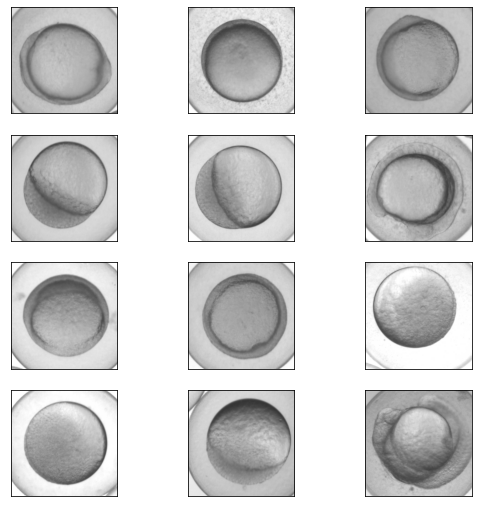

In [15]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image / 255, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(4, 3)
    for i in range(4):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Load model <a class="anchor" id="third-bullet"></a>

Define model

In [16]:
base_cnn = tf.keras.applications.resnet.ResNet50(
    weights="imagenet", input_shape=(img_height, img_width) + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = tf.keras.models.Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [17]:
anchor_input = tf.keras.layers.Input(name="anchor", shape=(img_height, img_width) + (3,))
positive_input = tf.keras.layers.Input(name="positive", shape=(img_height, img_width) + (3,))
negative_input = tf.keras.layers.Input(name="negative", shape=(img_height, img_width) + (3,))

distances = TNToolsDistanceLayer()(
    embedding(tf.keras.applications.resnet.preprocess_input(anchor_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(positive_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(negative_input)),
)

twin_network = tf.keras.models.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

twin_network_model = TNToolsModel(twin_network)

In [18]:
twin_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                            

Define callbacks

In [19]:
checkpoint_filepath = outFolder+'/checkpoints/'

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,
)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [21]:
log_dir = outFolder+"logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

Compile model

In [22]:
twin_network_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
                           metrics=['accuracy'])

## Training <a class="anchor" id="fourth-bullet"></a>

Run training:
- 100000 image triplets per dataset
- 3 runs, each run with a different dataset
- 10 epochs per dataset

Training iteration 1

In [23]:
history = twin_network_model.fit(train_dataset, 
                                 epochs=10, 
                                 callbacks=[early_stopping, 
                                            model_checkpoint_callback, 
                                            tensorboard_callback], 
                                 validation_data=val_dataset)

Epoch 1/10
200/200 [==============================] - 229s 1s/step - loss: 13.0158 - val_loss: 0.5668
Epoch 2/10
200/200 [==============================] - 208s 1s/step - loss: 0.6124 - val_loss: 0.1492
Epoch 3/10
200/200 [==============================] - 209s 1s/step - loss: 0.2621 - val_loss: 0.1150
Epoch 4/10
200/200 [==============================] - 216s 1s/step - loss: 0.1102 - val_loss: 0.0964
Epoch 5/10
200/200 [==============================] - 216s 1s/step - loss: 0.0846 - val_loss: 0.0022
Epoch 6/10
200/200 [==============================] - 214s 1s/step - loss: 0.1160 - val_loss: 0.0739
Epoch 7/10
200/200 [==============================] - 236s 1s/step - loss: 0.7259 - val_loss: 0.0781
Epoch 8/10
200/200 [==============================] - 211s 1s/step - loss: 0.4448 - val_loss: 0.2780
Epoch 9/10
200/200 [==============================] - 238s 1s/step - loss: 0.8330 - val_loss: 0.1561
Epoch 10/10
200/200 [==============================] - 237s 1s/step - loss: 0.2580 - val_l

In [24]:
twin_network_model.compute_output_shape(
    input_shape=((None, 224,224,3), 
                 (None, 224,224,3),
                 (None, 224,224,3))
)

(TensorShape([None]), TensorShape([None]))

In [25]:
embedding.save(outFolder+'/dir_dst_model_epochs_10/')
embedding.save_weights(outFolder+'/dir_dst_model_epochs_10_weights/')

INFO:tensorflow:Assets written to: C:/TwinNet-main/results/11_Training_Zebrafish1/model1/dir_dst_model_epochs_10/assets


Training iteration 2

In [26]:
log_dir = outFolder+"logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history2 = twin_network_model.fit(train_dataset2, epochs=20, initial_epoch=10, callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback], validation_data=val_dataset2)

Epoch 11/20
200/200 [==============================] - 226s 1s/step - loss: 0.4632 - val_loss: 0.2469
Epoch 12/20
200/200 [==============================] - 223s 1s/step - loss: 0.1925 - val_loss: 0.2543
Epoch 13/20
200/200 [==============================] - 222s 1s/step - loss: 0.1823 - val_loss: 0.1819
Epoch 14/20
200/200 [==============================] - 224s 1s/step - loss: 0.1557 - val_loss: 0.1446
Epoch 15/20
200/200 [==============================] - 220s 1s/step - loss: 0.1504 - val_loss: 0.1302
Epoch 16/20
200/200 [==============================] - 220s 1s/step - loss: 0.1442 - val_loss: 0.1624
Epoch 17/20
200/200 [==============================] - 224s 1s/step - loss: 0.1556 - val_loss: 0.1557
Epoch 18/20
200/200 [==============================] - 222s 1s/step - loss: 0.1350 - val_loss: 0.1121
Epoch 19/20
200/200 [==============================] - 219s 1s/step - loss: 0.1094 - val_loss: 0.0481
Epoch 20/20
200/200 [==============================] - 221s 1s/step - loss: 0.0946

In [27]:
embedding.save(outFolder+'/dir_dst_model_epochs_20/')
embedding.save_weights(outFolder+'/dir_dst_model_epochs_20_weights/')

INFO:tensorflow:Assets written to: C:/TwinNet-main/results/11_Training_Zebrafish1/model1/dir_dst_model_epochs_20/assets


Training iteration 3

In [28]:
log_dir = outFolder+"logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history3 = twin_network_model.fit(train_dataset3, epochs=30, initial_epoch=20, callbacks=[early_stopping, model_checkpoint_callback,tensorboard_callback], validation_data=val_dataset3)

Epoch 21/30
200/200 [==============================] - 241s 1s/step - loss: 0.2197 - val_loss: 0.2132
Epoch 22/30
200/200 [==============================] - 239s 1s/step - loss: 0.1780 - val_loss: 0.0780
Epoch 23/30
200/200 [==============================] - 246s 1s/step - loss: 0.1237 - val_loss: 0.1450
Epoch 24/30
200/200 [==============================] - 279s 1s/step - loss: 0.1322 - val_loss: 0.0664
Epoch 25/30
200/200 [==============================] - 280s 1s/step - loss: 0.1047 - val_loss: 0.0952
Epoch 26/30
200/200 [==============================] - 281s 1s/step - loss: 0.1258 - val_loss: 0.1006
Epoch 27/30
200/200 [==============================] - 285s 1s/step - loss: 0.0854 - val_loss: 0.0606
Epoch 28/30
200/200 [==============================] - 276s 1s/step - loss: 0.0896 - val_loss: 0.0866
Epoch 29/30
200/200 [==============================] - 280s 1s/step - loss: 0.1028 - val_loss: 0.1006
Epoch 30/30
200/200 [==============================] - 282s 1s/step - loss: 0.0807

In [29]:
embedding.save(outFolder+'/dir_dst_model_epochs_30/')
embedding.save_weights(outFolder+'/dir_dst_model_epochs_30_weights/')

INFO:tensorflow:Assets written to: C:/TwinNet-main/results/11_Training_Zebrafish1/model1/dir_dst_model_epochs_30/assets
